Import & Setup

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
pd.set_option("display.max_columns", None)   

Load Dataset

In [10]:
sentiment = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

In [11]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Initial Data Inspection

In [12]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [13]:
# sentiment data
print(sentiment.shape)
sentiment.isnull().sum()

(2644, 4)


timestamp         0
value             0
classification    0
date              0
dtype: int64

In [14]:
# Trader data
trades.head(), trades.shape
trades.isnull().sum()
trades.duplicated().sum()

0

Clean Columns

In [15]:
trades.columns = (
    trades.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

In [16]:
trades.columns

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')

Time Conversion & Alignment

In [17]:
# sentiment
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date
sentiment = sentiment.rename(columns={"classification": "sentiment"})

In [18]:
# trades
trades["date"] = pd.to_datetime(trades["timestamp_ist"],dayfirst=True,errors="coerce").dt.date

In [19]:
trades[["timestamp_ist","date"]].head(10)

,timestamp_ist,date
0,02-12-2024 22:50,2024-12-02
1,02-12-2024 22:50,2024-12-02
2,02-12-2024 22:50,2024-12-02
3,02-12-2024 22:50,2024-12-02
4,02-12-2024 22:50,2024-12-02
5,02-12-2024 22:50,2024-12-02
6,02-12-2024 22:50,2024-12-02
7,02-12-2024 22:50,2024-12-02
8,02-12-2024 22:50,2024-12-02
9,02-12-2024 22:50,2024-12-02


In [20]:
trades["date"].isna().sum()

0

Feature Engineering

In [21]:
trades["closed_pnl"] = trades["closed_pnl"].fillna(0)

trades["is_win"] = trades["closed_pnl"] > 0
trades["is_long"] = trades["side"].str.lower() == "buy"

Daily trader Aggregation

In [22]:
daily_trader = (
    trades
    .groupby(["account", "date"])
    .agg(
        daily_pnl=("closed_pnl", "sum"),
        trades_count=("closed_pnl", "count"),
        win_rate=("is_win", "mean"),
        avg_trade_size=("size_usd", "mean"),
        long_ratio=("is_long", "mean")
    )
    .reset_index()
)


In [23]:
daily_trader.head()

,account,date,daily_pnl,trades_count,win_rate,avg_trade_size,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0.000000,5089.718249,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0.000000,7976.664412,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0.000000,23734.500000,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0.000000,28186.666667,1.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,0.444444,17248.148148,0.444444


Merge with sentiment

In [24]:
data = daily_trader.merge(
    sentiment[["date", "sentiment"]],
    on="date",
    how="inner"
)

In [25]:
data.head()

,account,date,daily_pnl,trades_count,win_rate,avg_trade_size,long_ratio,sentiment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0.000000,5089.718249,0.000000,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0.000000,7976.664412,0.000000,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0.000000,23734.500000,0.000000,Extreme Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0.000000,28186.666667,1.000000,Extreme Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,0.444444,17248.148148,0.444444,Extreme Greed


In [26]:
data["sentiment"].value_counts()

sentiment
Greed            648
Fear             630
Extreme Greed    526
Neutral          376
Extreme Fear     160
Name: count, dtype: int64

Performence Comparison Fear vs Greed

In [27]:
performance_summary = (
    data
    .groupby("sentiment")
    .agg(
        avg_pnl=("daily_pnl", "mean"),
        pnl_volatility=("daily_pnl", "std"),
        avg_win_rate=("win_rate", "mean"),
        avg_trades=("trades_count", "mean"),
        avg_trade_size=("avg_trade_size", "mean")
    )
)

performance_summary

,avg_pnl,pnl_volatility,avg_win_rate,avg_trades,avg_trade_size
sentiment,,,,,
Extreme Fear,4619.439053,29534.839183,0.329659,133.750000,6773.464125
Extreme Greed,5161.922644,27496.863832,0.386387,76.030418,5371.637182
Fear,5328.818161,31659.771538,0.364033,98.153968,8975.928546
Greed,3318.100730,30599.040173,0.343559,77.628086,6427.866594
Neutral,3438.618818,17447.863645,0.355414,100.228723,6963.694861


Visual Analysis

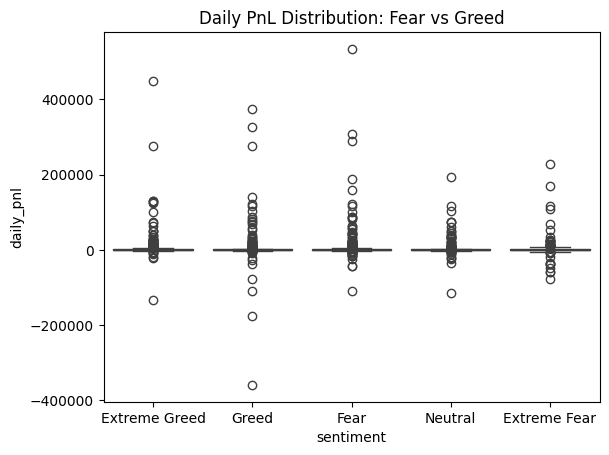

In [28]:
# Daily PnL Distribution
sns.boxplot(data=data, x="sentiment", y="daily_pnl")
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()


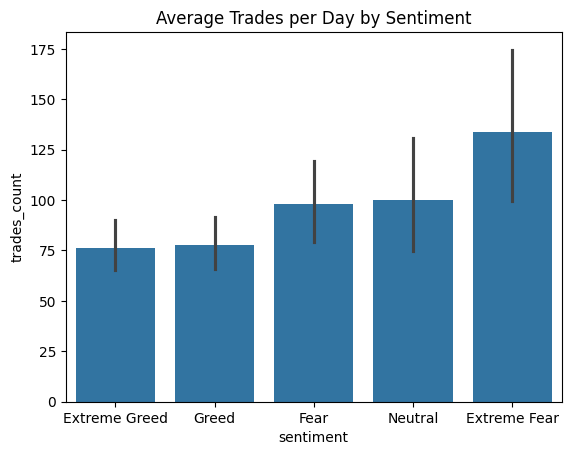

In [30]:
# Trade frequency
sns.barplot(data=data, x="sentiment", y="trades_count")
plt.title("Average Trades per Day by Sentiment")
plt.show()

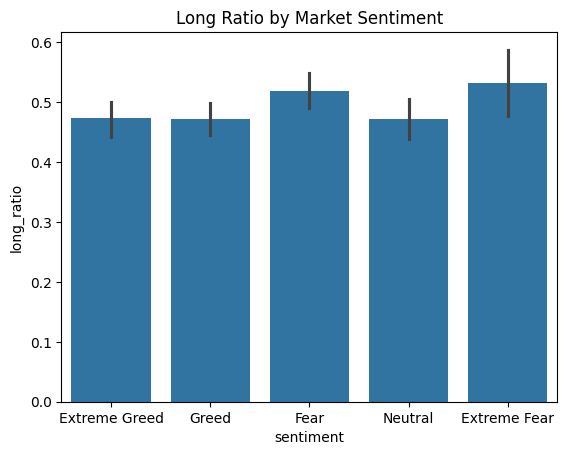

In [31]:
# Long & sort Bias
sns.barplot(data=data, x="sentiment", y="long_ratio")
plt.title("Long Ratio by Market Sentiment")
plt.show()


Trader Segmentation

In [32]:
# Frequent vs Infrequent Traders
trade_threshold = data["trades_count"].median()

data["frequency_segment"] = np.where(
    data["trades_count"] > trade_threshold,
    "Frequent",
    "Infrequent"
)

data.groupby(["sentiment", "frequency_segment"])["daily_pnl"].mean()


sentiment      frequency_segment
Extreme Fear   Frequent              6799.753651
               Infrequent             457.020275
Extreme Greed  Frequent              8437.437459
               Infrequent            1627.473851
Fear           Frequent             10311.492505
               Infrequent             913.034911
Greed          Frequent              5486.377107
               Infrequent            1401.949513
Neutral        Frequent              5759.162182
               Infrequent            1118.075454
Name: daily_pnl, dtype: float64

In [33]:
# Consistent vs Inconsistent Traders

pnl_std = (
    data
    .groupby("account")["daily_pnl"]
    .std()
    .reset_index(name="pnl_std")
)

data = data.merge(pnl_std, on="account", how="left")

consistency_threshold = data["pnl_std"].median()

data["consistency_segment"] = np.where(
    data["pnl_std"] <= consistency_threshold,
    "Consistent",
    "Inconsistent"
)

data.groupby(["sentiment", "consistency_segment"])["daily_pnl"].mean()

sentiment      consistency_segment
Extreme Fear   Consistent              1119.663483
               Inconsistent            6775.866425
Extreme Greed  Consistent              2285.145790
               Inconsistent           10553.914233
Fear           Consistent               359.250938
               Inconsistent            9355.881256
Greed          Consistent              1008.343003
               Inconsistent            6372.941595
Neutral        Consistent               589.367735
               Inconsistent            6854.387660
Name: daily_pnl, dtype: float64

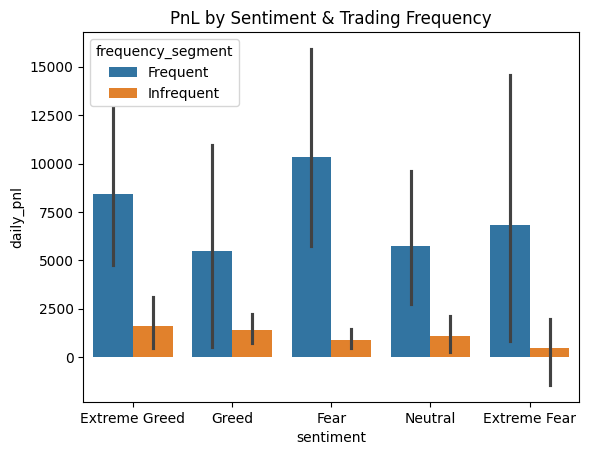

In [34]:
# segment visualization
sns.barplot(
    data=data,
    x="sentiment",
    y="daily_pnl",
    hue="frequency_segment"
)
plt.title("PnL by Sentiment & Trading Frequency")
plt.show()
